# 기초 설정


- `requirements.txt`에 명시된 버젼의 패키지 사용

In [ ]:
#공통 모듈 임포트
import os
import re  
import time
from tqdm.notebook import tqdm  # 반복문 진행상태 출력
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")  # 불필요한 경고 무시


# 넘파이
import numpy as np
assert np.__version__ == "1.19.5"


# 판다스
import pandas as pd
assert pd.__version__ == "1.1.5"


# seaborn
import seaborn as sns
assert sns.__version__ == "0.11.1"


# matplotlib
import matplotlib
assert matplotlib.__version__ == "3.3.4"


# 깔끔한 그래프 출력을 위해 
%matplotlib inline
sns.set_style("whitegrid")


# 한글폰트 설정 (맥 기준 - 운영체제에 맞게 변경)
import matplotlib.pyplot as plt
matplotlib.rcParams['axes.unicode_minus'] = False 
matplotlib.rcParams['font.family'] = "AppleGothic"  


print("기초 설정이 완료되었습니다.")

기초 설정이 완료되었습니다.


# Task 2


**고객 별 6개월 내, "대차" 또는 "추가구매" 가능성에 대한 예측모델을 개발.**

- 고객별 정보를 바탕으로 구매 유형을 **"대차", "추가구매", "구매안함"**의 세가지로 중 하나로 라벨링한 뒤, 이를 바탕으로 예측 모델을 훈련.

<br>

**구매 유형을 라벨링 하는 방법**

- 현재 주어진 과제는 **6개월 이내**에 재구매 유형 가능성을 예측하는 모델을 만드는 것이다.


&#8594; 따라서, **주어진 데이터에서 6개월을 단위로 구간을 후행 이동하며 고객별 파생변수(독립변수)를 수집하고, TASK 1에서 정의한 재구매유형을 참고해 종속변수를 생성한다.**

<br>

예시)

주어진 데이터에서 가장 최근 시점인 2017.12.31 로 부터 6개월 전인 2017.07.01을 기준으로 생각하자.
1. **2017.07.01** 을 기준으로 파생변수를 수집한다.
    - 수집할 파생변수의 종류는 추후 설명.
2. **2017.07.01 을 기준으로 해당 시점에서 향후 6개월 이내 (2017.07.01 ~ 2017.12.31) 사이에 출고된 차량이 있는 고객은 6개월 이내에 구매를 한 고객이다.**
    - TASK 1에서 정의한 재구매 유형을 그대로 사용해 라벨링 (대차/추가구매)
3. 이와 반대로, **(2)에 해당하는 고객들을 제외한 나머지 고객들은 향후 6개월 이내에 구매를 하지 않은 고객들이다.**
    - "구매안함"으로 라벨링
4. 각 라벨들의 비율을 일정하게 유지하기 위해 "구매안함"으로 라벨링 된 엔트리들 중 일부만 샘플링해 모델링용 데이터셋에 추가.
    - 샘플링 개수: 해당 단계에서 뽑힌 (추가구매수 + 대차수)/2


<br>

위 과정을 6개월씩 시점을 후행 이동하며 약 5년간의 파생변수들을 수집한다.

- ex) 2017.01.01 &#8594; 2016.07.01 &#8594; 2016.01.01 &#8594; ...
- 이렇게 할 경우, 동일한 고객이더라도 시점에 따라 파생변수가 달라지기 때문에 개별 고객의 ID는 중요하지 않음.
- 5년이라는 기간을 설정한 이유는, 사용할 독립변수 중 거주 주택 가격 등의 고객 정보는 시점에 영향을 받기 때문에 너무 오래된 데이터는 모델링에서 제외하기 위함.

<br>




## 데이터 불러오기

<br>

독립변수와 종속변수를 생성할 데이터셋을 정의.

In [ ]:
# 라벨링된 데이터 불러오기
df_full = pd.read_csv("./data/차량구매내역_라벨링.csv")

# 날짜 자료형으로 변환
df_full["WHOT_DT"] = pd.to_datetime(df_full["WHOT_DT"])
df_full["CAR_HLDG_FNH_DT"] = pd.to_datetime(df_full["CAR_HLDG_FNH_DT"])

# 차량 ID와 평당 주택 가격 예측치가 담긴 딕셔너리 불러오기
predictions = json.load(open("./data/PCE_PER_PYG_predictions.json"))

평당 주택 가격을 모델의 독립변수 중 하나로 사용할 것이므로, 앞서 회귀모형을 이용해 예측한 값들을 바탕으로 결측치를 보완.

In [ ]:
##### 평당 주택 가격 결측치 채우기 #####

# 평당 주택 가격이 결측치인 데이터셋
null_df = df_full[df_full.PCE_PER_PYG.isna()]

# 평당 주택 가격이 결측치가 아닌 데이터셋
notnull_df = df_full[~df_full.PCE_PER_PYG.isna()]

# 평당 주택 가격이 결측치인 데이터셋에 대해 예측값을 대입
null_df["PCE_PER_PYG"] = null_df["CAR_ID"].map(predictions)
null_df = null_df[~null_df.PCE_PER_PYG.isna()]

# 데이터를 하나로 다시 통합
df_full = null_df.append(notnull_df).sort_values(by = ["CUS_ID", "WHOT_DT"]).reset_index(drop=True)

/Users/dongwook/opt/anaconda3/envs/Hyundai/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
# 결측치가 제대로 채워졌는지 확인
df_full.PCE_PER_PYG.isna().sum()

0

In [ ]:
df_full.head()  # 평당 주택가격의 결측치가 채워진 데이터셋

,CUS_ID,PSN_BIZR_YN,SEX_SCN_NM,CUS_ADM_TRY_NM,CUS_N_ADMZ_NM,CUS_ADMB_NM,CLB_HOUS_PYG_NM,REAI_BZTC_AVG_PCE,B_YEAR,PCE_PER_PYG,...,CAR_CLASS,CAR_ENG_CAT,CAR_TRIM_CAT,TOTAL_NUM_PURCHASES,CUS_AGE,CUS_AGE_CAT,TYPE_PURCHASES,UNTIL_TOTAL_NUM_PURCHASES,UNTIL_NUM_CONTID_CARS,NUM_CONTACTS
0,AONEEOO010000113,N,남자,서울특별시,서초구,NaN,NaN,NaN,1955,5122.409180,...,승용_소형,알수없음,2007이전 데이터,2,51,50대,최초구매,0,0,1.0
1,AONEEOO010000113,N,남자,서울특별시,서초구,NaN,NaN,NaN,1955,5148.011230,...,승용_대형,가솔린,기타,2,56,50대,미분류,1,0,1.0
2,AONEEOO020000165,Y,남자,부산광역시,금정구,NaN,NaN,NaN,1951,1203.430542,...,승용_중형,알수없음,2007이전 데이터,2,54,50대,최초구매,0,0,4.0
3,AONEEOO020000165,Y,남자,부산광역시,금정구,NaN,NaN,NaN,1951,1185.211182,...,승용_고급,가솔린,중,2,59,50대,추가구매,1,1,4.0
4,AONEEOO020000290,Y,남자,인천광역시,계양구,NaN,NaN,NaN,1960,923.853088,...,RV_중형이상,가솔린,중,2,50,50대,최초구매,0,0,0.0


모델링에 사용하지 않을 특성들을 제거한 뒤, 범주형 특성들에 대한 자료를 수집하기 위해 원핫인코딩(one-hot encoding) 진행.

In [ ]:
# 사용하지 않을 칼럼 제거
drop_cols = ["CUS_N_ADMZ_NM", "CUS_ADMB_NM", "CLB_HOUS_PYG_NM", "REAI_BZTC_AVG_PCE", "CAR_NM", 
             "CAR_CGRD_NM_1", "CAR_CGRD_NM_2", "CUS_AGE_CAT", "TOTAL_NUM_PURCHASES", "CAR_HLDG_IS_CONTID",
             "UNTIL_TOTAL_NUM_PURCHASES", "UNTIL_NUM_CONTID_CARS", "CUS_AGE", "NUM_CONTACTS"]
df_full = df_full.drop(labels=drop_cols, axis=1)


# 행정시도명에 결측치가 존재하는 엔트리 삭제
df_full = df_full[~df_full.CUS_ADM_TRY_NM.isna()].reset_index(drop=True)  # 행정시도명에 결측치가 존재하는 엔트리 삭제

In [ ]:
# 원핫 인코딩으로 범주형 특성 인코딩하기 (groupby 메소드를 적용하기 위함)
from sklearn.preprocessing import OneHotEncoder

cat_attribs = ["CAR_CLASS", "CAR_ENG_CAT", "CAR_TRIM_CAT", "TYPE_PURCHASES"]
cat_data = df_full[cat_attribs]

onehot = OneHotEncoder()

onehot_data = pd.DataFrame(onehot.fit_transform(cat_data).toarray())
onehot_data.columns = pd.Series(onehot.get_feature_names()).apply(lambda x: re.search(r"_[\d\D]*", x).group()[1:])  # 특성명 전처리

# 기존 데이터에서 원핫인코딩될 특성들 삭제
df_full = df_full.drop(labels=["CAR_CLASS", "CAR_ENG_CAT", "CAR_TRIM_CAT"], axis=1).reset_index(drop=True)

# 원핫인코딩된 특성 추가
df_full = df_full.join(onehot_data)

# 모델링을 위한 데이터셋
print(df_full.shape)
df_full.head()

(1160693, 36)


,CUS_ID,PSN_BIZR_YN,SEX_SCN_NM,CUS_ADM_TRY_NM,B_YEAR,PCE_PER_PYG,CAR_ID,WHOT_DT,CAR_HLDG_FNH_DT,CAR_HLDG_DURATION,...,2007이전 데이터,기타,상,중,중상,하,대차,미분류,최초구매,추가구매
0,AONEEOO010000113,N,남자,서울특별시,1955,5122.409180,H1308031441VP6U069690,2006-06-27,2007-07-12,380.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,AONEEOO010000113,N,남자,서울특별시,1955,5148.011230,H1308060741EBBA077034,2011-08-01,2017-12-30,2343.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,AONEEOO020000165,Y,남자,부산광역시,1951,1203.430542,H1308052141BP5A053834,2005-02-26,2017-12-30,4690.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,AONEEOO020000165,Y,남자,부산광역시,1951,1185.211182,H1308070241ABAU090781,2010-01-06,2017-12-30,2915.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,AONEEOO020000290,Y,남자,인천광역시,1960,923.853088,H1308191081UBBU647205,2010-08-26,2011-10-28,428.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
# 전처리된 고객 접촉이력 데이터
contacts = pd.read_csv("./data/접촉이력_전처리.csv")
contacts.CNTC_DT = pd.to_datetime(contacts.CNTC_DT)
contacts.head()

,CNTC_SN,CUS_ID,CNTC_DT,CNTC_CHAN_CAT,CNTC_AFFR_SCN_CAT
0,172591627,AOZZZZO010000035,2015-05-04,대면,정비
1,172610507,AOZZZZO010000035,2015-05-04,대면,정비
2,306638131,AOZZZZO010000035,2016-12-02,대면,정비
3,306641393,AOZZZZO010000035,2016-12-02,대면,정비
4,344010325,AOZZZZO010000035,2017-02-15,대면,정비


## 샘플링

고객별 데이터에서 모델링에 사용될 파생변수들을 수집한다. (괄호 안은 데이터에서의 칼럼 명)


<br>

- groupby 메소드를 이용해서 데이터로부터 다음과 같은 파생변수들을 수집한다.
    - 개인사업자 여부 (PSN_BIZR_YN)
    - 성별 (SEX_SCN_NM)
    - 거주 행정시도 (CUS_ADM_TRY_NM)
    - 평당 주택 가격 (PCE_PER_PYG)
    - 현재 보유중인 차량의 종류별 개수 (승용_소형, 승용_준중형, 승용_중형, 승용_대형, 승용_고급, RV_준중형이하, RV_중형이상, 해치백, 스포츠카, 전기차)
    - 현재 보유중인 차량의 엔진 타입별 개수 (LPG, 가솔린, 디젤, 전기/하이브리드)
    - 현재 보유중인 차량의 트림 등급별 개수 (하, 중, 중상, 상)
    - 현재 보유 중인 차량의 보유 기간 평균 (CAR_HLDG_DURATION_CONTID)
    - 전체 구매 차량들의 보유 기간 평균 (CAR_HLDG_DURATION_TOTAL)
    - 전체 구매 차량들의 최소 보유 기간 (CAR_HLDG_DURATION_MIN)
    - 전체 구매 차량들의 최대 보유 기간 (CAR_HLDG_DURATION_MAX)
    - 과거 보유했던 차량들의 보유 기간 평균 (CAR_HLDG_DURATION_FINISHED)
    - 차량 구매 횟수 (NUM_TOTAL_CARS)
    - 현재 보유 차량 수 (NUM_CONTID_CARS)
    - 보유 종료 차량 수 (NUM_FINISHED_CARS)
    - 나이 (CUS_AGE)
    - 6개월 이내 접촉 횟수 (NUM_CONTACTS)
    - 6개월 이내 접촉 채널별 횟수 (대면, 비대면)
    - 6개월 이내 접촉 목적별 횟수 (정비, 상담, 견적, 서비스)
    - 현재 보유 차량 중 최초구매 차량 포함 여부 (최초구매_포함)
    - 구매 유형 (TYPE_PURCHASES)

<br>

In [ ]:
# 파생변수를 수집할 데이터셋
df_full.head()

,CUS_ID,PSN_BIZR_YN,SEX_SCN_NM,CUS_ADM_TRY_NM,B_YEAR,PCE_PER_PYG,CAR_ID,WHOT_DT,CAR_HLDG_FNH_DT,CAR_HLDG_DURATION,...,2007이전 데이터,기타,상,중,중상,하,대차,미분류,최초구매,추가구매
0,AONEEOO010000113,N,남자,서울특별시,1955,5122.409180,H1308031441VP6U069690,2006-06-27,2007-07-12,380.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,AONEEOO010000113,N,남자,서울특별시,1955,5148.011230,H1308060741EBBA077034,2011-08-01,2017-12-30,2343.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,AONEEOO020000165,Y,남자,부산광역시,1951,1203.430542,H1308052141BP5A053834,2005-02-26,2017-12-30,4690.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,AONEEOO020000165,Y,남자,부산광역시,1951,1185.211182,H1308070241ABAU090781,2010-01-06,2017-12-30,2915.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,AONEEOO020000290,Y,남자,인천광역시,1960,923.853088,H1308191081UBBU647205,2010-08-26,2011-10-28,428.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
def get_attribs(df, ids):
    """
    파생변수를 수집하기 위한 함수.

    파라미터
        df: 파생변수를 수집할 데이터프레임
        ids: 위 데이터프레임에 속한 고객 ID
    """
    global df_full      # 전체 구매내역 데이터
    global lower_date   # 기준 시점
    global contacts     # 고객 컨텍이력 데이터


    # 해당 구간에 속한 고객들의 과거 전체 구매 데이터
    total = df_full[df_full.CUS_ID.isin(ids)]
    total = total[(total.WHOT_DT < lower_date)]
    total = total.reset_index(drop=True) 

    # 기준시점 이후의 보유종료일을 기준시점으로 일괄 변경
    total["CAR_HLDG_FNH_DT"] = total.CAR_HLDG_FNH_DT.apply(lambda x: lower_date if (x > lower_date) else x) 
    total["CAR_HLDG_DURATION"] = (total["CAR_HLDG_FNH_DT"] - total["WHOT_DT"]).dt.days    # 기준 시점에서의 차량 보유 기간 계산

    # 기준시점에서 "전체" 차량들에 대한 고객별 groupby
    total_groupby_mean = total.groupby("CUS_ID").mean()  # 평균 보유 기간
    total_groupby_min = total.groupby("CUS_ID").min()    # 최소 보유 기간
    total_groupby_max = total.groupby("CUS_ID").max()    # 최대 보유 기간
    total_groupby_count = total.groupby("CUS_ID").count()["SEX_SCN_NM"]   # 구매횟수
    
    # 기준시점에서 "보유중인" 차량들에 대한 고객별 groupby
    contid = total[total.CAR_HLDG_FNH_DT == lower_date]       # 현재보유중 = 차량의 보유종료일이 기준시점이랑 동일 (전처리의 결과)
    contid_groupby_sum = contid.groupby("CUS_ID").sum()
    contid_groupby_mean = contid.groupby("CUS_ID").mean()
    contid_groupby_count = contid.groupby("CUS_ID").count()["SEX_SCN_NM"]

    # 기준시점에서 "보유 종료된" 차량들에 대한 고객별 groupby
    finished = total[total.CAR_HLDG_FNH_DT < lower_date]      # 차량의 보유종료일이 기준시점보다 이전
    finished_groupby_sum = finished.groupby("CUS_ID").sum()
    finished_groupby_mean = finished.groupby("CUS_ID").mean()
    finished_groupby_count = finished.groupby("CUS_ID").count()["SEX_SCN_NM"]


    # 기준시점으로부터 6개월 이내의 고객들의 접촉이력 데이터
    contacts_df = contacts[contacts.CUS_ID.isin(ids)]
    contacts_df = contacts_df[
                              (contacts_df.CNTC_DT < lower_date) & (contacts_df.CNTC_DT >= lower_date - relativedelta.relativedelta(months=6))
                              ]
    contacts_df = contacts_df.reset_index(drop=True)

    total_contact_count = contacts_df.groupby("CUS_ID").count()["CNTC_SN"]   # 접촉 횟수 groupby
    total_contact_groupby_count_channel = contacts_df.groupby(["CUS_ID", "CNTC_CHAN_CAT"]).count()["CNTC_SN"]       # 접촉 채널별 groupby
    total_contact_groupby_count_purpose = contacts_df.groupby(["CUS_ID", "CNTC_AFFR_SCN_CAT"]).count()["CNTC_SN"]   # 접촉 목적별 groupby




    # 고객들을 개별적으로 돌면서 파생변수 수집
    error_idx_list = []   # 에러가 발생한 인덱스
    for i in tqdm(range(len(df))):
        info = df.iloc[i, :]
        cus_id = info.CUS_ID

        ##### 현재 보유한 차량들에 대한 파생변수 #####
        start_idx = list(df.columns).index("RV_준중형이하")    # 해당 특성의 인덱스 번호
        end_idx = list(df.columns).index("하")                 # 해당 특성의 인덱스 번호
        start_idx_groupby = list(contid_groupby_sum.columns).index("RV_준중형이하")
        end_idx_groupby = list(contid_groupby_sum.columns).index("하")

        try:
            # 현재 보유중인 차량들의 차량등급, 엔진등급, 트림등급 별 개수
            df.iloc[i, start_idx:(end_idx+1)] = list(contid_groupby_sum.loc[cus_id][start_idx_groupby:(end_idx_groupby+1)])

            # 현재 보유한 차량들의 평균 보유 기간
            df.loc[i, "CAR_HLDG_DURATION_CONTID"] = contid_groupby_mean.loc[cus_id]["CAR_HLDG_DURATION"]

            # 현재 보유한 차량 수
            df.loc[i, "NUM_CONTID_CARS"] = contid_groupby_count.loc[cus_id]

        except:
            # 현재 보유한 차량이 없는 경우
            df.iloc[i, start_idx:(end_idx+1)] = 0
            df.loc[i, "CAR_HLDG_DURATION_CONTID"] = 0
            df.loc[i, "NUM_CONTID_CARS"] = 0


        # 현재 보유한 차량 중 최초구매 차량 포함 여부
        try:
            df.loc[i, "최초구매_포함"] = contid_groupby_sum.loc[cus_id]["최초구매"]

        except:
            df.loc[i, "최초구매_포함"] = 0


        ##### 과거 구매한 차량들에 대한 파생변수 #####

        try:
            # 과거 보유종료된 차량들의 평균 보유 기간
            df.loc[i, "CAR_HLDG_DURATION_FINISHED"] = finished_groupby_mean.loc[cus_id]["CAR_HLDG_DURATION"]

            # 과거 보유종료된 차량 수
            df.loc[i, "NUM_FINISHED_CARS"] = finished_groupby_count.loc[cus_id]

        except:
            df.loc[i, "CAR_HLDG_DURATION_FINISHED"] = 0
            df.loc[i, "NUM_FINISHED_CARS"] = 0


        try:
            # 여태까지 보유한 차량들의 최대/최소/평균 보유 기간
            df.loc[i, "CAR_HLDG_DURATION_MAX"] = total_groupby_max.loc[cus_id]["CAR_HLDG_DURATION"]
            df.loc[i, "CAR_HLDG_DURATION_MIN"] = total_groupby_min.loc[cus_id]["CAR_HLDG_DURATION"]
            df.loc[i, "CAR_HLDG_DURATION_TOTAL"] = total_groupby_mean.loc[cus_id]["CAR_HLDG_DURATION"]

            # 여태까지 총 구매횟수
            df.loc[i, "NUM_TOTAL_CARS"] = total_groupby_count.loc[cus_id]

            # 기준시점에서의 나이
            df.loc[i, "CUS_AGE"] = (lower_date.year - info.B_YEAR)

        # 해당 정보가 없는 경우는 에러로 분류 및 제거
        except: 
            error_idx_list.append(i)


       ##### 고객 접촉 데이터로부터의 파생변수들 #####

        # 대면 접촉 횟수
        try:
            df.loc[i, "대면"] = total_contact_groupby_count_channel.loc[cus_id]["대면"]
        except:
            df.loc[i, "대면"] = 0

        # 비대면 접촉 횟수
        try:
            df.loc[i, "비대면"] = total_contact_groupby_count_channel.loc[cus_id]["비대면"]
        except:
            df.loc[i, "비대면"] = 0

        # 정비 목적의 접촉 횟수
        try:
            df.loc[i, "정비"] = total_contact_groupby_count_purpose.loc[cus_id]["정비"]
        except:
            df.loc[i, "정비"] = 0

        # 상담 목적의 접촉 횟수
        try:
            df.loc[i, "상담"] = total_contact_groupby_count_purpose.loc[cus_id]["상담"]
        except:
            df.loc[i, "상담"] = 0

        # 견적 목적의 접촉 횟수
        try:
            df.loc[i, "견적"] = total_contact_groupby_count_purpose.loc[cus_id]["견적"]
        except:
            df.loc[i, "견적"] = 0

        # 서비스 목적의 접촉 횟수
        try:
            df.loc[i, "서비스"] = total_contact_groupby_count_purpose.loc[cus_id]["서비스"]
        except:
            df.loc[i, "서비스"] = 0

        # 6개월 이내 총 접촉 횟수
        try:
            df.loc[i, "NUM_CONTACTS"] = total_contact_count.loc[cus_id]
        except:
            df.loc[i, "NUM_CONTACTS"] = 0



    # 에러가 발생한 엔트리 제거
    df = df[~df.index.isin(error_idx_list)]

    return df

In [ ]:
## 독립 변수 수집 (약 두시간 정도 소요됩니다.)
from dateutil import relativedelta
import time
start_time = time.time()


# 기록할 파생변수에 대한 칼럼 추가
add_features = ["CAR_HLDG_DURATION_TOTAL", "CAR_HLDG_DURATION_CONTID", "CAR_HLDG_DURATION_FINISHED", 
                "CAR_HLDG_DURATION_MAX", "CAR_HLDG_DURATION_MIN", "NUM_TOTAL_CARS", "NUM_CONTID_CARS", "NUM_FINISHED_CARS", 
                "CUS_AGE", "NUM_CONTACTS", "대면", "비대면", "정비", "상담", "견적", "서비스", "최초구매_포함"]
df_full[add_features] = 0


# 재구매 엔트리들만 저장해둘 데이터프레임
target_df = pd.DataFrame(columns=df_full.columns)


upper_date = pd.to_datetime("2017.12.31")
lower_date = pd.to_datetime("2017.07.01") # 파생 변수를 수집할 기준이 되는 시점

for i in range(12):  
    # 6개월을 단위로 기간을 나누어 6년치의 데이터를 고려한다.
    print(upper_date)
    print(lower_date)


    #####################################################
    # 1. 해당 구간에 구매내역이 있는 엔트리 --> 재구매유형 그대로 사용
    ####################################################
    upper_limit = (df_full.WHOT_DT < upper_date)
    lower_limit = (df_full.WHOT_DT >= lower_date)
    temp = df_full[upper_limit & lower_limit]                  # 해당 구간에 구매내역이 있는 데이터
    ids = set(temp.CUS_ID.unique())                            # 해당 구간에 속한 고객 ID
    rest_ids = set(df_full.CUS_ID.unique()).difference(ids)    # 해당 구간에서 고려되지 않은 고객 ID


    ##### 파생변수 정의 및 추가 #####

    # 데이터를 수집할 대차/추가구매 데이터
    temp_pur = (temp[(temp.TYPE_PURCHASES == "대차") | (temp.TYPE_PURCHASES == "추가구매")]).reset_index(drop=True)
    
    # 파생변수 수집
    temp_pur = get_attribs(temp_pur, ids)

    # 데이터 기록
    target_df = target_df.append(temp_pur).reset_index(drop=True)



    #####################################################
    # 2. 해당 구간에서 구매내역이 없는 엔트리 --> "구매안함"으로 라벨링
    #####################################################

    # 앞서 고려되지 않은 고객들 (기준 시점에서 6개월 내에 구매 내역이 없는 고객들)
    df_rest = df_full[df_full.CUS_ID.isin(rest_ids)]
    df_rest = df_rest[(df_rest.WHOT_DT < lower_date) & (df_rest.WHOT_DT >= pd.to_datetime("2007.01.01"))]  # 2007년 이전 데이터는 샘플링에서 제외

    # 클래스별 비율을 비슷하게 유지하기 위해 일정 숫자만큼 "구매안함" 고객들을 샘플링
    sample_size = int(np.round(len(temp_pur) / 2))             
    temp_no_pur = df_rest.sample(sample_size).reset_index(drop=True)  # 기준 시점 이후 6개월 내에 구매 내역이 없는 고객들
    temp_no_pur["TYPE_PURCHASES"] = "구매안함"   # "구매안함"으로 라벨링
    ids = temp_no_pur.CUS_ID.unique()


    ##### 파생변수 정의 및 추가 #####

    # 파생변수 수집
    temp_no_pur = get_attribs(temp_no_pur, ids)
    
    # 데이터 기록
    target_df = target_df.append(temp_no_pur).reset_index(drop=True)   # 데이터 추가



    #####################################################
    # 3. 기준 시점 업데이트 (6개월씩 이동)
    #####################################################

    upper_date = upper_date - relativedelta.relativedelta(months=6)
    lower_date = lower_date - relativedelta.relativedelta(months=6)

    print(target_df.TYPE_PURCHASES.value_counts())  # 라벨 비율을 확인하기 위함
    print()

print("--- %s seconds ---" % (time.time() - start_time))  # 전체 실행시간 출력

2017-12-31 00:00:00
2017-07-01 00:00:00



대차      13353
구매안함    11210
추가구매     9068
Name: TYPE_PURCHASES, dtype: int64

2017-06-30 00:00:00
2017-01-01 00:00:00



대차      24903
구매안함    22225
추가구매    19548
Name: TYPE_PURCHASES, dtype: int64

2016-12-30 00:00:00
2016-07-01 00:00:00



대차      34125
구매안함    32076
추가구매    30028
Name: TYPE_PURCHASES, dtype: int64

2016-06-30 00:00:00
2016-01-01 00:00:00



대차      43944
구매안함    42100
추가구매    40257
Name: TYPE_PURCHASES, dtype: int64

2015-12-30 00:00:00
2015-07-01 00:00:00



대차      56952
구매안함    54832
추가구매    52712
Name: TYPE_PURCHASES, dtype: int64

2015-06-30 00:00:00
2015-01-01 00:00:00



대차      67901
구매안함    65062
추가구매    62223
Name: TYPE_PURCHASES, dtype: int64

2014-12-30 00:00:00
2014-07-01 00:00:00



대차      79634
구매안함    75547
추가구매    71460
Name: TYPE_PURCHASES, dtype: int64

2014-06-30 00:00:00
2014-01-01 00:00:00



대차      91287
구매안함    86140
추가구매    80993
Name: TYPE_PURCHASES, dtype: int64

2013-12-30 00:00:00
2013-07-01 00:00:00



대차      100379
구매안함     95597
추가구매     90815
Name: TYPE_PURCHASES, dtype: int64

2013-06-30 00:00:00
2013-01-01 00:00:00



대차      110508
구매안함    105067
추가구매     99627
Name: TYPE_PURCHASES, dtype: int64

2012-12-30 00:00:00
2012-07-01 00:00:00



대차      122204
구매안함    115721
추가구매    109240
Name: TYPE_PURCHASES, dtype: int64

2012-06-30 00:00:00
2012-01-01 00:00:00



대차      132672
구매안함    125341
추가구매    118013
Name: TYPE_PURCHASES, dtype: int64

--- 5974.4223709106445 seconds ---


In [ ]:
# 칼럼 순서 재지정
target_df = target_df[["CUS_ID", "PSN_BIZR_YN", "SEX_SCN_NM", "CUS_ADM_TRY_NM", "B_YEAR", "PCE_PER_PYG", "CAR_ID", "WHOT_DT", "CAR_HLDG_FNH_DT",
                        "CAR_HLDG_DURATION", "TYPE_PURCHASES", "RV_준중형이하", "RV_중형이상", "스포츠카", "승용_소형", "승용_준중형", "승용_중형",
                        "승용_대형", "승용_고급", "전기차", "해치백", "LPG", "가솔린", "디젤", "알수없음", "전기/하이브리드", "2007이전 데이터",
                        "기타", "하", "중", "중상", "상", "대차", "미분류", "최초구매", "추가구매", "CAR_HLDG_DURATION_TOTAL", "CAR_HLDG_DURATION_CONTID",
                        "CAR_HLDG_DURATION_FINISHED", "CAR_HLDG_DURATION_MAX", "CAR_HLDG_DURATION_MIN", "NUM_TOTAL_CARS", "NUM_CONTID_CARS", "NUM_FINISHED_CARS",
                        "CUS_AGE", "NUM_CONTACTS", "대면", "비대면", "정비", "상담", "견적", "서비스", "최초구매_포함"
                        ]]

In [ ]:
# 사용하지 않을 변수 삭제
cols_drop = ["CUS_ID", "B_YEAR", "CAR_ID", "WHOT_DT", "CAR_HLDG_FNH_DT", 
             "알수없음", "2007이전 데이터", "기타", "최초구매", "미분류",
             "대차", "추가구매", "CAR_HLDG_DURATION"]

target_df = target_df.drop(cols_drop, axis=1).reset_index(drop=True)
print(target_df.shape)
target_df.head()

(376026, 40)


,PSN_BIZR_YN,SEX_SCN_NM,CUS_ADM_TRY_NM,PCE_PER_PYG,TYPE_PURCHASES,RV_준중형이하,RV_중형이상,스포츠카,승용_소형,승용_준중형,승용_중형,승용_대형,승용_고급,전기차,해치백,LPG,가솔린,디젤,전기/하이브리드,하,중,중상,상,CAR_HLDG_DURATION_TOTAL,CAR_HLDG_DURATION_CONTID,CAR_HLDG_DURATION_FINISHED,CAR_HLDG_DURATION_MAX,CAR_HLDG_DURATION_MIN,NUM_TOTAL_CARS,NUM_CONTID_CARS,NUM_FINISHED_CARS,CUS_AGE,NUM_CONTACTS,대면,비대면,정비,상담,견적,서비스,최초구매_포함
0,N,남자,서울특별시,3309.716553,대차,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1312.0,1779.0,845.0,1779,845,2,1.0,1,56,0,0,0,0,0,0,0,0.0
1,N,남자,경상북도,510.377716,대차,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1358.0,1358.0,0.0,2704,12,2,2.0,0,53,1,1,0,1,0,0,0,1.0
2,Y,남자,경상북도,494.222870,대차,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5324.0,5324.0,0.0,5324,5324,1,1.0,0,60,2,1,1,1,1,0,0,1.0
3,Y,남자,대구광역시,1409.090909,추가구매,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,745.0,745.0,0.0,745,745,1,1.0,0,51,2,0,2,0,2,0,0,1.0
4,N,남자,대구광역시,1116.071777,대차,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1360.0,1360.0,0.0,1360,1360,1,1.0,0,73,2,2,0,2,0,0,0,1.0


In [ ]:
# 수집한 데이터 저장
target_df.to_csv("./data/모델링_최총.csv", index=False)

## 모델링

**6개월 이내 고객별 대차 가능성을 모델링 한다.**

<br>

앞서 정의한 데이터셋을 바탕으로 분류기를 학습시킨다.

- **pycaret 모듈을 이용해 모델 간 비교 및 하이퍼파라미터 튜닝을 진행.**
- **트리 기반의 모델**들을 사용해 앙상블 모델을 학습.
    - 트리 기반의 모델은 **수치형 변수의 scaling이 불필요**하고, **outlier에 robust**하며, **변수중요도를 시각화**할 수 있는 장점과 더불어 **proba 메소드를 이용해 구체적인 확률값을 산출**할 수 있기 때문에 해당 과제의 모델링에 적합하다고 판단.
    - **일반화 성능을 향상시키기 위해 앙상블 분류기를 정의.**

**독립변수**

<수치형>

- 평당 주택 가격 (PCE_PER_PYG)
- 현재 보유중인 차량의 종류별 개수 (승용_소형, 승용_준중형, 승용_중형, 승용_대형, 승용_고급, RV_준중형이하, RV_중형이상, 해치백, 스포츠카, 전기차)
- 현재 보유중인 차량의 엔진 타입별 개수 (LPG, 가솔린, 디젤, 전기/하이브리드)
- 현재 보유중인 차량의 트림 등급별 개수 (하, 중, 중상, 상)
- 현재 보유 중인 차량의 보유 기간 평균 (CAR_HLDG_DURATION_CONTID)
- 전체 구매 차량들의 보유 기간 평균 (CAR_HLDG_DURATION_TOTAL)
- 전체 구매 차량들의 최소 보유 기간 (CAR_HLDG_DURATION_MIN)
- 전체 구매 차량들의 최대 보유 기간 (CAR_HLDG_DURATION_MAX)
- 과거 보유했던 차량들의 보유 기간 평균 (CAR_HLDG_DURATION_FINISHED)
- 차량 구매 횟수 (NUM_TOTAL_CARS)
- 현재 보유 차량 수 (NUM_CONTID_CARS)
- 보유 종료 차량 수 (NUM_FINISHED_CARS)
- 나이 (CUS_AGE)
- 6개월 이내 접촉 횟수 (NUM_CONTACTS)
- 6개월 이내 접촉 채널별 횟수 (대면, 비대면)
- 6개월 이내 접촉 목적별 횟수 (정비, 상담, 견적, 서비스)


<범주형>

- 성별 (SEX_SCN_NM)
- 현재 보유 차량 중 최초구매 차량 포함 여부 (최초구매_포함)

cf) 여러번의 시행착오 결과, 고객의 거주 행정시도와 개인사업자 여부는 분류기의 성능에 별다른 영향이 없었기 때문에 최종 모델링에서 제외.

<br>

**종속변수**

- 구매 유형 (TYPE_PURCHASES)


### 모델링을 위한 데이터 전처리

- 트리 기반의 분류기를 사용할 예정이므로, 수치형 특성에 대해서는 별도의 전처리 불필요.

- 범주형 특성인 "고객의 성별" 원핫 인코딩 진행



In [ ]:
# 모델링에 사용할 데이터셋 불러오기
df = pd.read_csv("./data/모델링_최총.csv")

In [ ]:
# "대차"와 "구매안함"만 추출
df = df[(df.TYPE_PURCHASES == "대차") | (df.TYPE_PURCHASES == "구매안함")]

In [ ]:
# 모델링용 데이터에서의 라벨 수
print(df.TYPE_PURCHASES.value_counts())

df.head()

대차      132672
구매안함    125341
Name: TYPE_PURCHASES, dtype: int64


,PSN_BIZR_YN,SEX_SCN_NM,CUS_ADM_TRY_NM,PCE_PER_PYG,TYPE_PURCHASES,RV_준중형이하,RV_중형이상,스포츠카,승용_소형,승용_준중형,...,NUM_FINISHED_CARS,CUS_AGE,NUM_CONTACTS,대면,비대면,정비,상담,견적,서비스,최초구매_포함
0,N,남자,서울특별시,3309.716553,대차,0.0,0.0,0.0,0.0,0.0,...,1,56,0,0,0,0,0,0,0,0.0
1,N,남자,경상북도,510.377716,대차,0.0,1.0,0.0,1.0,0.0,...,0,53,1,1,0,1,0,0,0,1.0
2,Y,남자,경상북도,494.222870,대차,0.0,1.0,0.0,0.0,0.0,...,0,60,2,1,1,1,1,0,0,1.0
4,N,남자,대구광역시,1116.071777,대차,0.0,0.0,0.0,0.0,0.0,...,0,73,2,2,0,2,0,0,0,1.0
5,N,남자,경기도,1419.729126,대차,0.0,0.0,0.0,0.0,1.0,...,2,72,0,0,0,0,0,0,0,1.0


In [ ]:
# 독립변수 및 종속변수 정의
X = df.drop("TYPE_PURCHASES", axis=1)
y = df["TYPE_PURCHASES"].reset_index(drop=True)

print(X.shape)
print(y.shape)

(258013, 39)
(258013,)


In [ ]:
# 원핫 인코딩으로 범주형 특성 인코딩하기
from sklearn.preprocessing import OneHotEncoder

cat_attribs = ["SEX_SCN_NM"]
cat_data = X[cat_attribs]

onehot = OneHotEncoder()

onehot_data = pd.DataFrame(onehot.fit_transform(cat_data).toarray())
onehot_data.columns = pd.Series(onehot.get_feature_names()).apply(lambda x: re.search(r"_[\d\D]*", x).group()[1:])

# 사용하지 않을 변수 삭제
X = X.drop(labels=["PSN_BIZR_YN", "SEX_SCN_NM", "CUS_ADM_TRY_NM"], axis=1).reset_index(drop=True)

# 원핫인코딩된 특성 추가
X = X.join(onehot_data).astype(float)

print(X.shape)
X.head()

(258013, 38)


,PCE_PER_PYG,RV_준중형이하,RV_중형이상,스포츠카,승용_소형,승용_준중형,승용_중형,승용_대형,승용_고급,전기차,...,NUM_CONTACTS,대면,비대면,정비,상담,견적,서비스,최초구매_포함,남자,여자
0,3309.716553,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,510.377716,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
2,494.222870,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
3,1116.071777,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,2.0,2.0,0.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0
4,1419.729126,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


### 변수중요도

본격적인 모델링을 진행하기 전에, 간단한 랜덤포레스트 분류기를 바탕으로 사용할 독립변수들의 변수중요도를 개괄적으로 파악.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

(y_pred_rf == y_test).sum() / len(y_test)

0.8414206870891727

- 하이퍼 파라미터 튜닝을 하지 않은 기본적인 랜덤 포레스트 분류기는 약 84% 정도의 예측 정확도를 보인다.

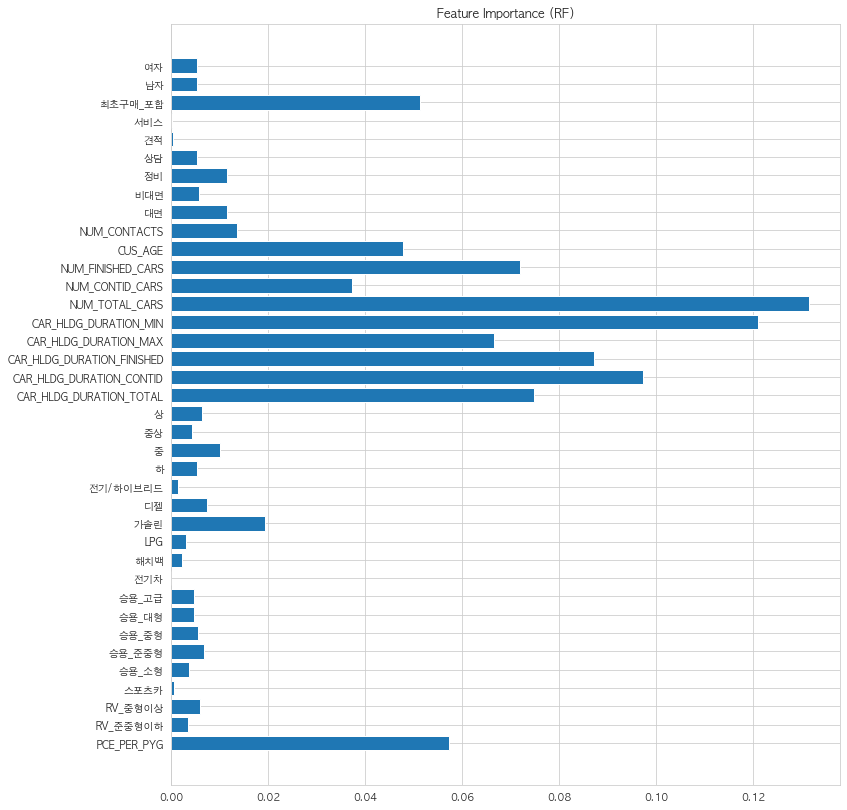

In [ ]:
plt.figure(figsize=(12,14))
plt.barh(X.columns, rnd_clf.feature_importances_)
plt.title("Feature Importance (RF)")
plt.show()

- 변수 중요도를 시각화한 결과, 차량의 "보유기간"과 "보유 차량수"와 관련한 변수가 상대적으로 높은 중요도를 보인다.

### pycaret을 이용한 모델 비교

pycaret 모듈을 사용해 Auto ML을 진행.

- 트리 기반의 부스팅 모형들의 성능을 비교.

In [ ]:
# pycaret의 메소드를 적용하기 위한 형식에 맞춰 데이터프레임 정의
data = X.astype(float).copy()
data["Target"] = y
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,PCE_PER_PYG,RV_준중형이하,RV_중형이상,스포츠카,승용_소형,승용_준중형,승용_중형,승용_대형,승용_고급,전기차,...,대면,비대면,정비,상담,견적,서비스,최초구매_포함,남자,여자,Target
0,796.666667,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,대차
1,4535.294118,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,2.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,구매안함
2,733.333333,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,대차
3,1300.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,대차
4,2372.093023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,구매안함


In [ ]:
# Importing module and initializing setup
from pycaret.classification import *

# pycaret 초기 설정 (가용가능한 GPU가 있다고 가정)
clf1 = setup(data = data, target = 'Target', use_gpu = True)

# 5개의 트리 기반 예측기의 성능을 비교
best = compare_models(fold=5, include = ['xgboost', 'lightgbm', 'catboost', "et", "rf"])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.8446,0.9214,0.8140,0.8752,0.8435,0.6896,0.6914,8.930
lightgbm,Light Gradient Boosting Machine,0.8442,0.9210,0.8106,0.8772,0.8426,0.6888,0.6910,1.434
xgboost,Extreme Gradient Boosting,0.8434,0.9201,0.8135,0.8734,0.8424,0.6872,0.6889,1.560
rf,Random Forest Classifier,0.8401,0.9153,0.8005,0.8779,0.8374,0.6807,0.6836,15.264
et,Extra Trees Classifier,0.8311,0.9086,0.7892,0.8704,0.8278,0.6629,0.6660,14.736


### pycaret을 이용한 하이퍼 파라미터 튜닝

In [ ]:
# pycaret 초기 환경 설정
from pycaret.classification import *

clf = setup(data = data, target = 'Target', use_gpu = True, n_jobs=-1, silent=True)   # GPU를 사용

,Description,Value
0,session_id,8727
1,Target,Target
2,Target Type,Binary
3,Label Encoded,"구매안함: 0, 대차: 1"
4,Original Data,"(258013, 39)"
5,Missing Values,False
6,Numeric Features,35
7,Categorical Features,3
8,Ordinal Features,False
9,High Cardinality Features,False


#### LightGBM

In [ ]:
# LightGBM 분류기 정의
lgbm_clf = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8444,0.9201,0.8088,0.8784,0.8422,0.6893,0.6916
1,0.8467,0.9235,0.8142,0.8782,0.8450,0.6938,0.6957
2,0.8467,0.9241,0.8091,0.8826,0.8442,0.6940,0.6965
3,0.8445,0.9210,0.8128,0.8752,0.8429,0.6893,0.6912
4,0.8433,0.9206,0.8135,0.8726,0.8420,0.6870,0.6886
5,0.8482,0.9236,0.8110,0.8836,0.8457,0.6968,0.6993
6,0.8480,0.9225,0.8130,0.8815,0.8459,0.6963,0.6986
7,0.8449,0.9214,0.8087,0.8793,0.8425,0.6902,0.6925
8,0.8424,0.9232,0.8031,0.8793,0.8395,0.6853,0.6880
9,0.8420,0.9184,0.8061,0.8762,0.8397,0.6845,0.6868


In [ ]:
# LightGBM 하이퍼파라미터 튜닝
import time
start_time = time.time()
tuned_lgbm = tune_model(lgbm_clf, fold=5, n_iter=100)
print("--- %s seconds ---" % (time.time() - start_time))

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8455,0.9223,0.8139,0.8763,0.8439,0.6914,0.6932
1,0.8457,0.9228,0.8117,0.8784,0.8437,0.6918,0.6939
2,0.8448,0.9221,0.8128,0.8759,0.8432,0.6900,0.6919
3,0.8466,0.9223,0.8124,0.8796,0.8446,0.6937,0.6958
4,0.8427,0.9214,0.8074,0.8764,0.8405,0.6859,0.6881
Mean,0.8451,0.9222,0.8116,0.8773,0.8432,0.6905,0.6926
SD,0.0013,0.0005,0.0022,0.0014,0.0014,0.0026,0.0026


--- 943.3870487213135 seconds ---


In [ ]:
#### 최적의 하이퍼파라미터 저장 ####
import json

best_params = tuned_lgbm.get_params()

# json 파일로 저장하기 위해 자료형 변환
for keys in best_params.keys():
    try:
        best_params[keys] = float(best_params[keys])
    except:
        pass

# 하이퍼 파라미터 저장
save_path = "./data/model_weights/lgbm_params.json"
json.dump(best_params, open(save_path, "w"))

#### XGBoost

In [ ]:
# XGBoost 분류기 정의
xgb_clf = create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8428,0.9196,0.8118,0.8731,0.8413,0.6860,0.6878
1,0.8462,0.9233,0.8163,0.8757,0.8450,0.6928,0.6945
2,0.8452,0.9239,0.8131,0.8765,0.8436,0.6909,0.6928
3,0.8436,0.9196,0.8144,0.8723,0.8424,0.6875,0.6891
4,0.8415,0.9201,0.8156,0.8676,0.8408,0.6833,0.6845
5,0.8454,0.9232,0.8145,0.8756,0.8440,0.6912,0.6930
6,0.8485,0.9214,0.8192,0.8775,0.8473,0.6974,0.6990
7,0.8462,0.9215,0.8117,0.8793,0.8442,0.6928,0.6950
8,0.8416,0.9221,0.8058,0.8756,0.8393,0.6836,0.6859
9,0.8413,0.9174,0.8100,0.8716,0.8397,0.6829,0.6847


In [ ]:
# XGBoost 하이퍼파라미터 튜닝
import time
start_time = time.time()
tuned_xgb = tune_model(xgb_clf, fold=5, n_iter=100)
print("--- %s seconds ---" % (time.time() - start_time))

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8440,0.9161,0.8202,0.8686,0.8437,0.6883,0.6894
1,0.8436,0.9163,0.8183,0.8694,0.8431,0.6876,0.6888
2,0.8424,0.9175,0.8196,0.8661,0.8422,0.6850,0.6860
3,0.8438,0.9169,0.8176,0.8701,0.8430,0.6878,0.6891
4,0.8411,0.9153,0.8131,0.8689,0.8401,0.6826,0.6841
Mean,0.8430,0.9164,0.8177,0.8686,0.8424,0.6862,0.6875
SD,0.0011,0.0007,0.0025,0.0014,0.0013,0.0022,0.0021


--- 1847.5817716121674 seconds ---


In [ ]:
#### 최적의 하이퍼파라미터 저장 ####

import json

best_params = tuned_xgb.get_params()

# json 파일로 저장하기 위해 자료형 변환
for keys in best_params.keys():
    try:
        best_params[keys] = float(best_params[keys])
    except:
        pass

# 하이퍼 파라미터 저장
save_path = "./data/model_weights/xgb_params.json"
json.dump(best_params, open(save_path, "w"))

#### 랜덤포레스트

In [ ]:
# 랜덤포레스트 분류기 정의
rf_clf = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8404,0.9138,0.8030,0.8758,0.8378,0.6814,0.6838
1,0.8440,0.9174,0.8055,0.8804,0.8413,0.6886,0.6912
2,0.8427,0.9180,0.8025,0.8805,0.8397,0.6859,0.6888
3,0.8391,0.9142,0.7989,0.8766,0.8360,0.6787,0.6816
4,0.8378,0.9155,0.8038,0.8702,0.8357,0.6760,0.6781
5,0.8411,0.9175,0.8019,0.8780,0.8382,0.6828,0.6855
6,0.8460,0.9176,0.8061,0.8836,0.8431,0.6926,0.6954
7,0.8417,0.9156,0.8003,0.8804,0.8384,0.6840,0.6870
8,0.8383,0.9160,0.7964,0.8772,0.8349,0.6772,0.6803
9,0.8375,0.9123,0.7981,0.8744,0.8345,0.6756,0.6783


In [ ]:
# 랜덤포레스트 하이퍼파라미터 튜닝
import time
start_time = time.time()
tuned_rf = tune_model(rf_clf, fold=5, n_iter=50)
print("--- %s seconds ---" % (time.time() - start_time))

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8442,0.9189,0.8082,0.8785,0.8419,0.6889,0.6912
1,0.8441,0.9198,0.8020,0.8834,0.8407,0.6887,0.6918
2,0.8442,0.9196,0.8099,0.8771,0.8422,0.6888,0.6910
3,0.8442,0.9196,0.8033,0.8826,0.8411,0.6890,0.6919
4,0.8419,0.9184,0.8035,0.8781,0.8392,0.6843,0.6870
Mean,0.8437,0.9193,0.8054,0.8800,0.8410,0.6879,0.6906
SD,0.0009,0.0005,0.0031,0.0025,0.0011,0.0018,0.0018


--- 2782.436352968216 seconds ---


In [ ]:
#### 최적의 하이퍼파라미터 저장 ####
import json

best_params = tuned_rf.get_params()

# json 파일로 저장하기 위해 자료형 변환
for keys in best_params.keys():
    try:
        best_params[keys] = float(best_params[keys])
    except:
        pass

# 하이퍼 파라미터 저장
save_path = "./data/model_weights/rf_params.json"
json.dump(best_params, open(save_path, "w"))

### 앙상블 모델

#### 모델 정의

앞서 구한 최적의 하이퍼파라미터를 바탕으로 개별 예측기를 정의

In [ ]:
#### 하이퍼 파라미터들의 자료형 재변환 (float -> int) ####

# LightGBM
lgbm_params = json.load(open("./data/model_weights/lgbm_params.json"))

lgbm_params["bagging_freq"] = int(lgbm_params["bagging_freq"])
lgbm_params["max_depth"] = int(lgbm_params["max_depth"])
lgbm_params["min_child_samples"] = int(lgbm_params["min_child_samples"])
lgbm_params["n_estimators"] = int(lgbm_params["n_estimators"])
lgbm_params["n_jobs"] = -1
lgbm_params["num_leaves"] = int(lgbm_params["num_leaves"])
lgbm_params["random_state"] = 42
lgbm_params["subsample_for_bin"] = int(lgbm_params["subsample_for_bin"])


# XGBoost
xgb_params = json.load(open("./data/model_weights/xgb_params.json"))

xgb_params["max_depth"] = int(xgb_params["max_depth"])
xgb_params["n_estimators"] = int(xgb_params["n_estimators"])
xgb_params["n_jobs"] = -1
xgb_params["num_parallel_tree"] = int(xgb_params["num_parallel_tree"])
xgb_params["random_state"] = 42
xgb_params["reg_lambda"] = int(xgb_params["reg_lambda"])
xgb_params["verbosity"] = 0   
xgb_params.pop("monotone_constraints", None)      # 사용하지 않을 하이퍼파라미터
xgb_params.pop("interaction_constraints", None)   # 사용하지 않을 하이퍼파라미터
xgb_params.pop('gpu_id', None)  
xgb_params.pop("tree_method", None)  # XGBoost에서 GPU를 사용하도록 설정하려면 해당 코드를 삭제


# 랜덤포레스트
rf_params = json.load(open("./data/model_weights/rf_params.json"))
rf_params["max_depth"] = int(rf_params["max_depth"])
rf_params["min_samples_leaf"] = int(rf_params["min_samples_leaf"])
rf_params["min_samples_split"] = int(rf_params["min_samples_split"])
rf_params["n_estimators"] = int(rf_params["n_estimators"])
rf_params["n_jobs"] = -1
rf_params["random_state"] = 42
rf_params["verbose"] = 0

In [ ]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

# 앙상블에 사용될 개별 예측기 객체 정의
lightgbm_clf = LGBMClassifier(**lgbm_params)
xgboost_clf = XGBClassifier(**xgb_params)
random_forest_clf = RandomForestClassifier(**rf_params)

#### 모델 훈련

투표 (Voting) 기반의 앙상블 분류기를 정의.

In [ ]:
# Train/Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
# 투표 앙상블 모델 정의
from sklearn.ensemble import VotingClassifier

named_estimators = [
    ("random_forest_clf", random_forest_clf),
    ("xgboost_clf", xgboost_clf),
    ("lightgbm_clf", lightgbm_clf)
]

voting_clf = VotingClassifier(named_estimators)
voting_clf.fit(X_train, y_train)

/Users/dongwook/opt/anaconda3/envs/Hyundai/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(bootstrap=1.0,
                                                     class_weight='balanced',
                                                     criterion='entropy',
                                                     max_depth=8,
                                                     max_features=1.0,
                                                     min_samples_leaf=6,
                                                     min_samples_split=5,
                                                     n_estimators=170,
                                                     n_jobs=-1, oob_score=0.0,
                                                     random_state=42,
                                                     warm_start=0.0)),
                             ('xgboost_clf',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                               

In [ ]:
# 훈련된 모델 저장
import pickle

save_path = "./data/model_weights/ensemble_model.pkl"
with open(save_path, 'wb') as file:
    pickle.dump(voting_clf, file)

#### 모델 평가

평가지표로는 정밀도와 재현율의 조화 평균인 **F1 Score**를 사용.

- ROC 곡선을 통해 시각화.

In [ ]:
# 저장된 모델 불러오기
import pickle

save_path = "./data/model_weights/ensemble_model.pkl"
voting_clf = pickle.load(open(save_path, 'rb'))

In [ ]:
# 테스트 데이터에 대한 예측
y_pred = voting_clf.predict(X_test)

# 여러 지표를 바탕으로 모델 평가
def get_classification_report(y_test, y_pred):
    from sklearn.metrics import classification_report
    report = classification_report(y_test, y_pred, output_dict=True)
    df_classification_report = pd.DataFrame(report).transpose()
    df_classification_report = df_classification_report.sort_values(by=['f1-score'], ascending=False)
    return df_classification_report

get_classification_report(y_test, y_pred)

,precision,recall,f1-score,support
구매안함,0.819441,0.877360,0.847412,25212.000000
accuracy,0.845629,0.845629,0.845629,0.845629
macro avg,0.846898,0.846338,0.845608,51603.000000
weighted avg,0.847525,0.845629,0.845567,51603.000000
대차,0.874355,0.815316,0.843804,26391.000000


In [ ]:
# 클래스별 확률값을 반환하도록 하기 위해 간접 투표 방식으로 변경
voting_clf.voting = "soft"

# 각 클래스의 확률값 계산
from sklearn.model_selection import cross_val_predict

y_proba = cross_val_predict(voting_clf, X_test, y_test, cv=5, method="predict_proba")

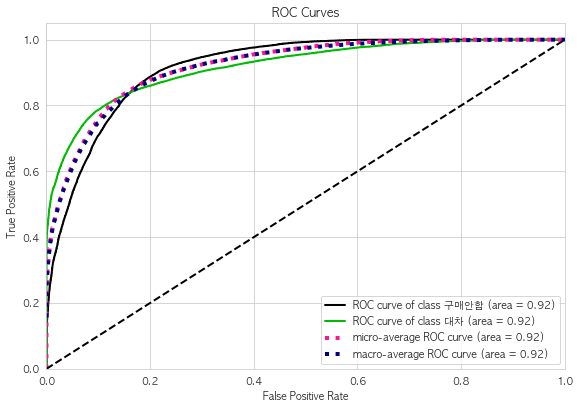

In [ ]:
# ROC 곡선 시각화
import scikitplot as skplt

fig = plt.figure()
ax = fig.add_axes([0.3,0.2,1.2,1.2])
skplt.metrics.plot_roc(y_test, y_proba, ax=ax)
plt.show()

최종적으로 약 84% 정도의 F1-score를 보임.

- 현재 "대차" 클래스의 precision이 약 87%로, "구매안함" 클래스보다 약 6%p 정도 높다.
- 비즈니스적인 관점에서 차량을 구매하지 않을 고객들 보다는 **차량을 구매할 고객들을 더 잘 예측하는 것이 더 중요하므로 좋은 결과라고 할 수 있다.**

#### 모델 활용 예시

- 고객별로 모델링에 사용된 독립변수만 정의할 수 있으면, 새로운 고객이 향후 6개월 이내에 대차를 할 가능성을 예측할 수 있다.

In [ ]:
# 클래스별 확률값을 반환하도록 하기 위해 간접 투표 방식으로 변경
if voting_clf.voting != "soft":
    voting_clf.voting = "soft"

# 대차 확률 계산
pred_proba = np.round(voting_clf.predict_proba(X_test), 3)
prob_nobuy = pred_proba[:, 0]
prob_buy = pred_proba[:, 1]

print(voting_clf.classes_)

['구매안함' '대차']


In [ ]:
# 훈련된 모델을 이용한 고객별 6개월 이내 "대차 가능성" 예측 예시

score_df = pd.DataFrame({"구매안함_확률": prob_nobuy, "대차_확률":prob_buy, "실제결과": list(y_test)})
score_df

,구매안함_확률,대차_확률,실제결과
0,0.835,0.165,구매안함
1,0.280,0.720,대차
2,0.821,0.179,구매안함
3,0.624,0.376,구매안함
4,0.664,0.336,구매안함
...,...,...,...
51598,0.489,0.511,대차
51599,0.430,0.570,대차
51600,0.719,0.281,구매안함
51601,0.304,0.696,대차
